## Installations & Imports

In [19]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [20]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [21]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [22]:
%pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [24]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import re
from wordcloud import WordCloud
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from gensim import corpora, models

## Accessing Titles

In [25]:
# Define the path to OAuth2 credentials JSON file
creds_path = r'C:\Users\cathe\practical-data-science-tutorial\src\data\credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Fantastic Four altmetric-data-individual'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_names = ['Health and medical sciences', 'Social sciences', 'Business, economics and management']

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

article_names = []

for specific_sheet_name in specific_sheet_names:
    # Open the Google Sheet
    sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

    # Get list of article names from the sheet
    papers = sheet.col_values(3)[1:]

    # Add all article names to a single list
    article_names.extend(papers)

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\gspread\auth.py:63: DeprecationWarning: [Deprecated][in version 6.0.0]: client_factory will be replaced by gspread.http_client types
  warnings.warn(


In [26]:
article_names[0]

'The psychological impact of quarantine and how to reduce it: rapid review of the evidence'

In [27]:
len(article_names)

1242

## Exploration of Titles

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


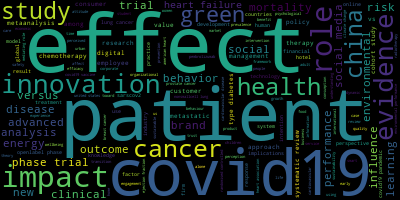

In [28]:
article_names_cleaned = np.vectorize(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))(article_names)

article_names_lower = np.vectorize(lambda x: x.lower())(article_names_cleaned)

all_titles = ','.join(list(article_names_lower))

wordcloud = WordCloud()

wordcloud.generate(all_titles)

wordcloud.to_image()

## Preprocessing Titles

In [29]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [30]:
# Define stopwords to remove
custom_stopwords = set(['the', 'a'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Tokenize the title (break down into words)
    words = word_tokenize(title_lower)

    # Remove stopwords
    words = [word for word in words if word not in custom_stopwords]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Map POS tags to WordNet tags for lemmatisation
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        else:
            return wordnet.VERB

    # Lemmatisation of verbs (converts all verbs that are the same to the infinitive) & removal of nouns
    lemmatised_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words if not pos.startswith('N')]
    #lemmatised_words = [lemmatizer.lemmatize(word, pos='v') for word, pos in tagged_words]

    # Join the words back into a processed title
    processed_title = ' '.join(lemmatised_words)

    return processed_title

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names]
preprocessed_titles[0:4]

['psychological of and how to reduce it rapid of',
 'global regional and national and live with for 354 and for 195 and 19902017 systematic for global of 2017',
 'novel of global',
 'and italy what next']

## Document-Term Matrix (DTM)

In [31]:
vectorizer = CountVectorizer()

# Fit and transform the preprocessed titles to create the DTM
dtm = vectorizer.fit_transform(preprocessed_titles)

# Get the feature names (terms) from the vectoriser
feature_names = vectorizer.get_feature_names_out()
dtm_array = dtm.toarray()

# Print the DTM and feature names
print("Document-Term Matrix (DTM):")
print(dtm_array)
print("Feature Names (Terms):")
print(feature_names)

Document-Term Matrix (DTM):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Names (Terms):
['000' '012' '067' ... 'young' 'zero' 'zoledronic']


## Latent Dirichlet Allocation (LDA)

### Using sklearn

In [32]:
# Number of topics
num_topics = 3

# Initialize the LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the LDA model to the DTM
lda.fit(dtm_array)

# Get the topic-word distributions
topic_word_distributions = lda.components_

# Get the document-topic distributions
document_topic_distributions = lda.transform(dtm_array)

# Print the top words for each topic
n_top_words = 5
for topic_idx, topic in enumerate(topic_word_distributions):
    top_terms_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_terms = [feature_names[i] for i in top_terms_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_terms)}")

# Print the topic distribution for each document
for doc_idx, doc_topics in enumerate(document_topic_distributions):
    print(f"Article {doc_idx + 1}: {doc_topics}")

Topic 1: in, and, for, of, with
Topic 2: of, and, on, in, social
Topic 3: of, and, in, with, for
Article 1: [0.18956585 0.77473056 0.0357036 ]
Article 2: [0.01797784 0.01846464 0.96355753]
Article 3: [0.0894036  0.81079738 0.09979902]
Article 4: [0.84439991 0.0847771  0.070823  ]
Article 5: [0.06274235 0.87705948 0.06019818]
Article 6: [0.05259332 0.3566104  0.59079628]
Article 7: [0.85308736 0.08430155 0.06261109]
Article 8: [0.1514812 0.7238124 0.1247064]
Article 9: [0.03680749 0.03435166 0.92884085]
Article 10: [0.06758432 0.86301037 0.06940531]
Article 11: [0.03185613 0.03044644 0.93769743]
Article 12: [0.027468   0.02913112 0.94340088]
Article 13: [0.05935481 0.88278891 0.05785629]
Article 14: [0.49130784 0.03034604 0.47834612]
Article 15: [0.11424766 0.76867424 0.1170781 ]
Article 16: [0.07153317 0.8502388  0.07822803]
Article 17: [0.02787218 0.6767759  0.29535192]
Article 18: [0.08482741 0.50734998 0.40782261]
Article 19: [0.05146773 0.0539081  0.89462417]
Article 20: [0.0696692

### Using genism

In [33]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Define stopwords to remove
stop_words = stopwords.words('english')
stop_words.extend(['covid19', 'sarscov2'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

# Map POS tags to WordNet tags for lemmatisation
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Break down into individual words
    words = word_tokenize(title_lower)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Lemmatisation of words & removal of words that aren't adjectives/verbs/adverbs
    lemmatised_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words if get_wordnet_pos(pos)]

    return lemmatised_words

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [34]:
# Create a dictionary of terms in the preprocessed titles
id2word = corpora.Dictionary(preprocessed_titles)

# Convert the preprocessed titles into a bag-of-words representation
# where each document is represented as a list of (term_id, term_frequency) pairs
corpus = [id2word.doc2bow(word) for word in preprocessed_titles]

In [35]:
# Define the number of topics you want the LDA model to discover
num_topics = 5

# Initialize and train an LDA model using multicore processing for efficiency
lda_model = models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Apply the trained LDA model to the corpus to get topic distributions for each document
doc_lda = lda_model[corpus]

# Print the discovered topics along with their top terms
lda_model.print_topics()

[(0,
  '0.021*"social" + 0.011*"metastatic" + 0.008*"cardiovascular" + 0.008*"advance" + 0.007*"american" + 0.007*"learn" + 0.007*"use" + 0.007*"type" + 0.006*"systematic" + 0.006*"united"'),
 (1,
  '0.008*"new" + 0.008*"green" + 0.007*"severe" + 0.007*"environmental" + 0.007*"social" + 0.006*"early" + 0.006*"economic" + 0.006*"rural" + 0.006*"chronic" + 0.006*"metastatic"'),
 (2,
  '0.020*"environmental" + 0.018*"green" + 0.018*"randomise" + 0.013*"advance" + 0.011*"human" + 0.008*"social" + 0.008*"openlabel" + 0.006*"systematic" + 0.006*"organizational" + 0.006*"pandemic"'),
 (3,
  '0.012*"financial" + 0.012*"cardiovascular" + 0.012*"environmental" + 0.010*"perceive" + 0.009*"social" + 0.009*"new" + 0.009*"clinical" + 0.008*"green" + 0.008*"learn" + 0.008*"randomise"'),
 (4,
  '0.031*"social" + 0.010*"global" + 0.010*"reduce" + 0.009*"sustainable" + 0.008*"cardiovascular" + 0.008*"corporate" + 0.008*"industrial" + 0.006*"clinical" + 0.006*"pandemic" + 0.006*"human"')]

In [36]:
# Enable the use of pyLDAvis within a Jupyter Notebook
pyLDAvis.enable_notebook()

# Prepare the data for visualisation
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

AttributeError: module 'pyLDAvis' has no attribute 'gensim'